### Import modules

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import fnmatch
import os
from astropy.io import fits
from scipy import interpolate
from scipy.ndimage import rotate
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from textwrap import wrap
import scipy.ndimage as ndimage
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import functions as f
import pandas as pd
from scipy.optimize import curve_fit
from numpy import asarray as ar,exp

### Functions

In [3]:
def createfolder(dirName):
    try:
    # Create target Directory
       os.mkdir(dirName)
    except FileExistsError:
        print()#("Directory " , dirName ,  " already exists")

def create_dir(dirname):
    if not os.path.isdir(dirname):
        os.makedirs(dirname, exist_ok=True)

def plotImage(image, lim):
    n = image.shape[0]

    fig, ax = plt.subplots()
    image = np.arcsinh(image)
    max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    ps = 3.6 #mas per pixel for zimpol
    d = n * ps / 2
    plt.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))
    #plt.plot(0, 0, "+", color="red")
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    plt.xlabel('mas')
    plt.ylabel("mas")
    plt.colorbar()
    plt.tight_layout

def LoadImage_dec (dir,annulus):

    files = os.listdir(dir)
    for fil in files:
        if fnmatch.fnmatch(fil, '*'+annulus+'_decon.fits'):
            hdu = fits.open(dir+fil)
            image = hdu[0].data
            ps =3.6
            n=image.shape[0]
            d=(n-1)/2
            x = np.linspace(-d, d, n)
            y = np.linspace(-d, d, n)
            x2, y2 = np.meshgrid(x, y)
            R = np.sqrt(x2**2+y2**2)
    return image, R, x, y, d,x2,y2

def LoadImage(dirdat,filename):
    dir =dirdat
    psfile =  filename
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, psfile):
            hdulPSF = fits.open(dir + file)
            fit = hdulPSF[0].data


    return fit

### Set up

In [36]:
# folder names for each target
stars=['01.SCI_UMon','01.SCI_AR_Pup']
ref_of_sci={'01.SCI_AR_Pup':'REF_HD75885','01.SCI_UMon':'01.SCI_UMon'} # the corresponding scientific targets, SPHERE proposals
disk_incl_pa={'01.SCI_AR_Pup':[75,45],'UMon':[25,144],'01.SCI_UMon':[25,144],'V709_Car':[34,13],'HR4049_20190108':[49,63],'HR4049_20190107':[49,63],"HR4049_combined":[49,63],'HR4226':[0,1]} # Kluska_2019 for HR4049 V709Car, UMon from Andrych2023, AR Pup...have to check, this are from my table, HR4226 - just circle
starnames = {'01.SCI_UMon':'U Mon','01.SCI_AR_Pup':'AR Pup'}

star = stars[0]

incl_pa=disk_incl_pa[star]

# number of bands
# fittypes=['1','2']
fittypes = ['1']

# bands
# band=['V','I']
band=['H']

# camera
# camera='ZIMPOL'
camera='IRDIS'

# pixelscale
# ps=3.6        # ZIMPOL
ps = 12.27      # IRDIS

# base directory
dirdat0 = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/'
# directory where data is stored
dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unres+PSFcorr/'+camera+'/'
# directory where outputs are stored
figfolder=dirdat0+'HMS_checks/'
create_dir(figfolder)

normlim=45

### Transforming to disk coordinates

In [86]:
def rotatetodisk(dir, angle, stokes = 'Q_phi', band = 'I', lim = 110, verbose = True):
    '''
    Input parameters
    '''
    # load data
    stokes_to_rotate = LoadImage(dir,f'{star}_{band}_{stokes}_corr_smearing_tel+unres+PSF_smear.fits')
    # rotate image
    rotated_stokes = rotate(stokes_to_rotate, angle, reshape=False)

    # plot and save
    lim = lim                               # constricts the range of pixels
    center = rotated_stokes.shape[0]/2      # calculates center of image, assuming star resides there

    plt.imshow(np.arcsinh(rotated_stokes),vmin=-7, vmax=7)
    plt.axhline(y=center, color='white', linestyle='--', linewidth=1)
    plt.axvline(x=center, color='white', linestyle='--', linewidth=1)
    plt.title(f"{starnames[star]}'s {stokes} in Disk Coordinates, {band} band")

    plt.xlim(center-lim, center+lim)
    plt.ylim(center-lim, center+lim)

    plt.colorbar()
    plt.savefig(figfolder+f'/{star}_{stokes}_{band}_diskcoords.png',dpi=300)
    if verbose:
        plt.show()

    return rotated_stokes

In [87]:
# omega is the angle at which the 'front' of the disk (i.e. brightest/closest) is located at the bottom
omega_i = 131
omega_v = 128

q_phi_i = rotatetodisk(dirdat, omega_i, band='I', stokes='Q_phi',lim=80)
q_phi_v = rotatetodisk(dirdat, omega_v, band='V', stokes='Q_phi',lim=80)

UnboundLocalError: cannot access local variable 'fit' where it is not associated with a value

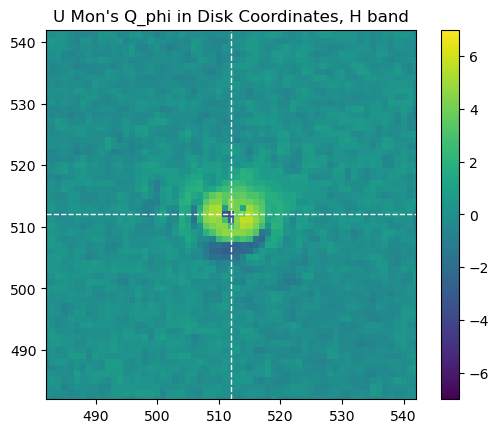

In [238]:
if band[0] == 'H':
    omega_h = 144-90
    q_phi_h = rotatetodisk(dirdat, omega_h, band='H', stokes='Q_phi',lim=30)

In [89]:
# the paper for each equation is found here: https://www.aanda.org/articles/aa/pdf/2021/11/aa40405-21.pdf
# Quadrant polarization parameters for the scattered light of circumstellar disks: H. M. Schmid

def transformtodisk(dir, angle, stokes = 'Q', band = 'I', lim = 110, verbose = True):
    '''
    This function is used to transform from sky coordinates to disk coordinates for Q_disk and U_disk based
    the equations given in the paper. As we want to preserve the brightness distribution from each lobe, we
    cannot simply rotate the image, and instead we perform a geometric rotation as defined by the paper.

    Input parameters
    '''
    # load data
    Q = LoadImage(dir,f'{star}_{band}_Q_corr_tel+unres.fits')
    U = LoadImage(dir,f'{star}_{band}_U_corr_tel+unres.fits')

    # rotate image
    omega = np.deg2rad(angle)               # convert omega to radians
    cos2w = np.cos(2*omega)
    sin2w = np.sin(2*omega)

    if stokes == 'Q':
        rotated_stokes = Q * cos2w + U * sin2w       # equation for Q_disk (7)
    elif stokes == 'U':
        rotated_stokes = U * cos2w - Q * sin2w       # equation for U_disk (8)

    # plot and save
    lim = lim
    center = rotated_stokes.shape[0]/2

    plt.imshow(np.arcsinh(rotated_stokes),vmin=-7, vmax=7)
    plt.axhline(y=center, color='white', linestyle='--', linewidth=1)
    plt.axvline(x=center, color='white', linestyle='--', linewidth=1)
    plt.title(f"{starnames[star]}'s {stokes} in Disk Coordinates, {band} band")

    plt.xlim(center-lim, center+lim)
    plt.ylim(center-lim, center+lim)

    plt.colorbar()
    plt.savefig(figfolder+f'/{star}_{stokes}_{band}_diskcoords.png',dpi=300)
    if verbose:
        plt.show()

    return rotated_stokes


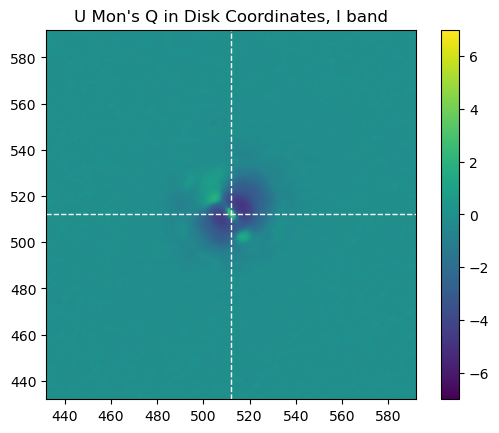

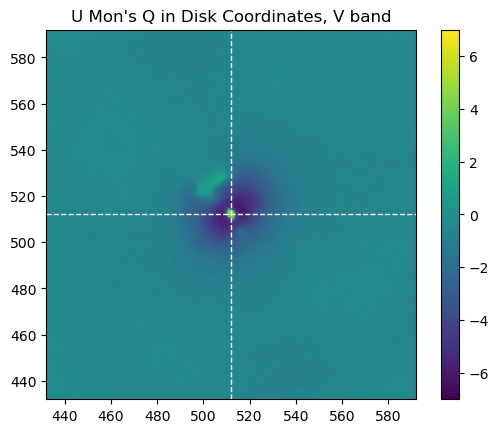

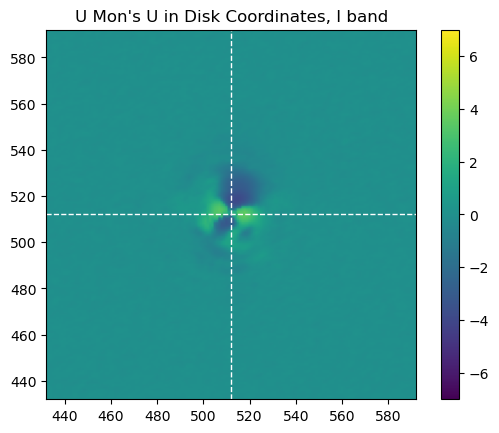

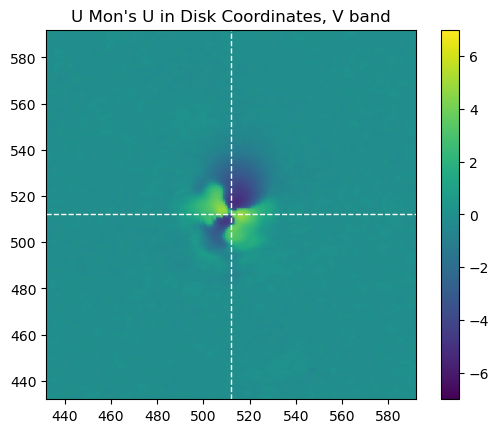

In [9]:
q_i = transformtodisk(dirdat, omega_i, band='I', stokes='Q',lim=80)
q_v = transformtodisk(dirdat, omega_v, band='V', stokes='Q',lim=80)
u_i = transformtodisk(dirdat, omega_i, band='I', stokes='U',lim=80)
u_v = transformtodisk(dirdat, omega_v, band='V', stokes='U',lim=80)

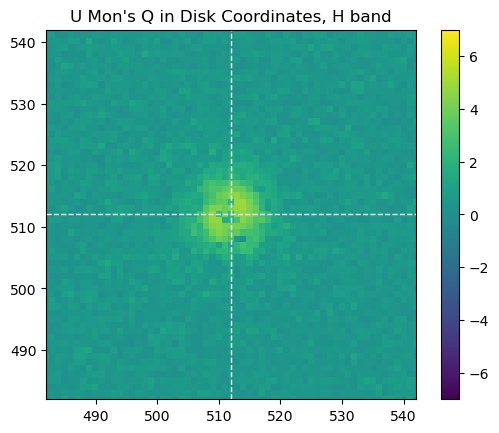

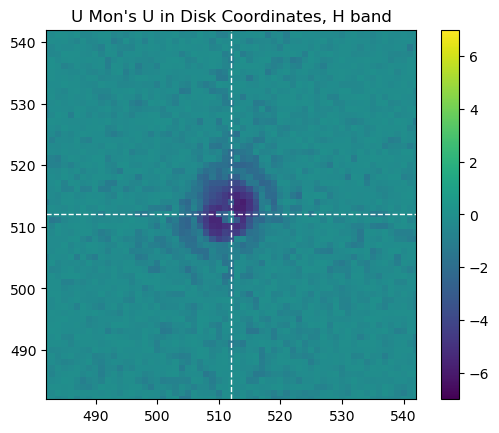

In [90]:
if band[0] == 'H':
    q_h = transformtodisk(dirdat, omega_h, band='H', stokes='Q',lim=30)
    u_h = transformtodisk(dirdat, omega_h, band='H', stokes='U',lim=30)

In [143]:
omega_h

54

#### Recalculating Q_phi

Let's see if the Q$_{disk}$ and U$_{disk}$ calculated can reproduce Q$_\phi$:

In [228]:
n = 1024
omega = omega_h
omega_rad = np.deg2rad(omega)

In [239]:
xr = np.linspace(-n/2, n/2, num=n)
yr = np.linspace(-n/2, n/2, num=n)
x0 = 0.5
y0 = 0.5
xr = xr-x0
yr = yr-y0
Xr, Yr = np.meshgrid(xr, yr)

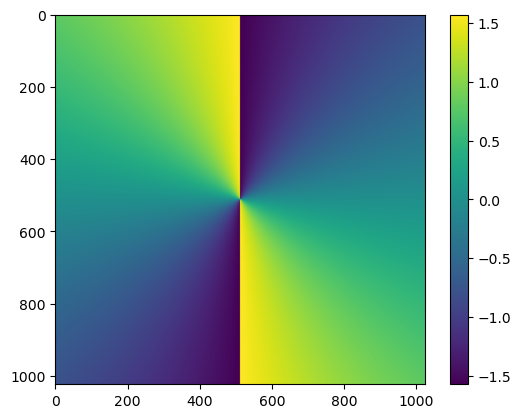

In [240]:
phi_skylight = np.arctan(Yr/Xr)
plt.imshow(phi_skylight)
plt.colorbar()

In [241]:
Q = q_h * np.cos(2 * omega_rad) - u_h * np.sin(2 * omega_rad)
U = q_h * np.sin(2 * omega_rad) + u_h * np.cos(2 * omega_rad)

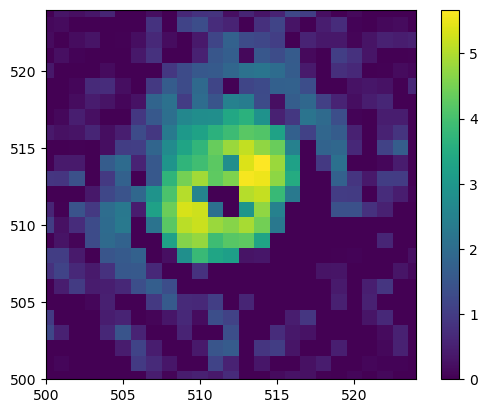

In [242]:
plt.imshow(np.arcsinh(Q))
plt.xlim(500,524)
plt.ylim(500,524)
plt.colorbar()

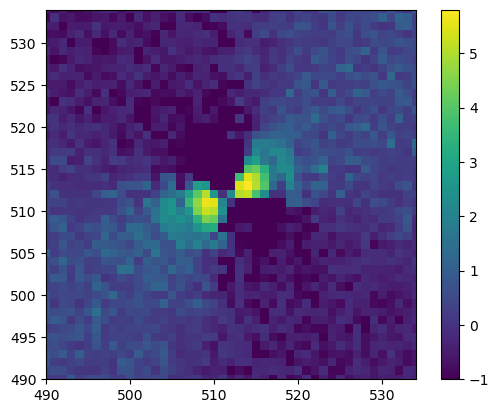

In [243]:
q_phi = Q * np.cos(2 * phi_skylight) + U * np.sin(2 * phi_skylight)
q_phi = rotate(q_phi,0)
plt.imshow(np.arcsinh(q_phi),vmin=-1)
plt.xlim(500-10,524+10)
plt.ylim(500-10,524+10)
plt.colorbar()

### Characterisation of Q and U quadrant values

Quadrant 1: PA = 0–90°

Quadrant 2: PA = 90–180°

Quadrant 3: PA = 180–270°

Quadrant 4: PA = 270–360°

In [10]:
# detailed characterisation of Q and U quadrant values for barely resolved targets can help to determine front disc side (p.8)


#### Q_disk

In [63]:
def QPHIquadrant_polarisation(Qphi, center=None, r_in=0, r_out=None, show_masks=True, stokes='Q_disk', band='I'):
    """
    Compute quadrant-integrated Q_phi/U_phi values.

    North = up, South = down, East = left, West = right

    Q_phi:
      - 0° = North-West, 90° = North-East, 180° = South-East, 270° = South-West
    """

    ny, nx = Qphi.shape
    if center is None:
        cx, cy = (nx-1)/2, (ny-1)/2
    else:
        cx, cy = center

    # pixel grids
    y, x = np.indices(Qphi.shape)
    dx, dy = x - cx,  y - cy
    r = np.sqrt(dx**2 + dy**2)
    pa = (np.degrees(np.arctan2(dy, dx)) + 360) % 360  # Position angle [0,360)

    # annulus mask
    if r_out is None:
        r_out = np.max(r)
    mask = (r >= r_in) & (r <= r_out)

    # quadrants
    # q1 = mask & (pa >= 0+45)   & (pa < 90+45)   #N
    # q2 = mask & (pa >= 90+45)  & (pa < 180+45)  #E
    # q3 = mask & (pa >= 180+45) & (pa < 270+45)  #S
    # q4 = mask & (pa >= 270+45) & (pa < 360+45)  #W
    q1 = mask & (pa >= 45)   & (pa < 135)  #N 000
    q2 = mask & (pa >= 135)  & (pa < 225)  #E 090
    q3 = mask & (pa >= 225) & (pa < 315)   #S 180
    q4 = mask & ((pa >= 315) | (pa < 45))  ## 270

    # integrate
    Q1 = np.sum(Qphi[q1])
    Q2 = np.sum(Qphi[q2])
    Q3 = np.sum(Qphi[q3])
    Q4 = np.sum(Qphi[q4])

    Q1_abs = np.sum(np.abs(Qphi[q1]))
    Q2_abs = np.sum(np.abs(Qphi[q2]))
    Q3_abs = np.sum(np.abs(Qphi[q3]))
    Q4_abs = np.sum(np.abs(Qphi[q4]))

    # ratios
    ratios = {
        "090/270": (Q2_abs-Q4_abs)/(Q2_abs + Q4_abs),  # Left-right
        "000/180": (Q1_abs) / (Q3_abs),                # Back-front
    }

        # --- Plot overlay ---

    image = Qphi.copy()
    plot_mask = mask.astype(float)
    plot_mask[plot_mask == 0] = np.nan   # hide everything outside r_in–r_out
    Qphi = image * plot_mask

    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(Qphi, origin="lower", cmap="inferno")#np.max(np.abs(Qphi)))
    ax.set_title(f'{star}, {stokes} Quadrants in {band} band')
    ax.set_ylim(512-r_out,512+r_out)
    ax.set_xlim(512-r_out,512+r_out)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Intensity")

    # draw cross-lines for quadrants
    ax.plot([cx, 0], [cy, ny], "w--", lw=1)  # NW boundary
    ax.plot([cx, nx], [cy, ny], "w--", lw=1)  # NE boundary
    ax.plot([cx, nx], [cy, 0], "w--", lw=1)   # SE boundary
    ax.plot([cx, 0], [cy, 0], "w--", lw=1)    # SW boundary

    # mark center
    ax.plot(cx, cy, "yo", markersize=6)

    # quadrant labels
    ax.text(cx, cy+r_out-5, "$Q_{000}$", color="white", fontsize=12, ha="center") # top
    ax.text(cx+r_out-5, cy, "$Q_{090}$", color="white", fontsize=12, ha="center")  # left
    ax.text(cx, cy-r_out+5, "$Q_{180}$", color="white", fontsize=12, ha="center")  # bottom
    ax.text(cx-r_out+5, cy, "$Q_{270}$", color="white", fontsize=12, ha="center")   # right

    plt.savefig(figfolder+f'/{star}_{stokes}_{band}_quadrants.png',dpi=300)

    # --- Individual quadrant masks ---
    if show_masks:
        masks = [q1, q2, q3, q4]
        titles = ["Q1 (0–90°)", "Q2 (90–180°)", "Q3 (180–270°)", "Q4 (270–360°)"]

        fig, axs = plt.subplots(1, 4, figsize=(16, 4))
        for i, (m, t) in enumerate(zip(masks, titles)):
            mask_img = np.zeros_like(Qphi, dtype=float)
            mask_img[m] = Qphi[m]
            axs[i].imshow(mask_img, origin="lower", cmap="inferno")
            axs[i].set_title(t)
            axs[i].axis("off")
        plt.show()



    plt.show()
    Q_sum = Q1 + Q2 + Q3 + Q4

    return {"Q000": Q1, "Q090": Q2, "Q180": Q3, "Q270": Q4, "ratios": ratios,
            "Q000_norm": Q1/Q_sum, "Q090_norm": Q2/Q_sum, "Q180_norm": Q3/Q_sum, "Q270_norm": Q4/Q_sum,
            "Q000_abs":Q1_abs, "Q090_abs":Q2_abs, "Q180_abs":Q3_abs, "Q270_abs":Q4_abs}

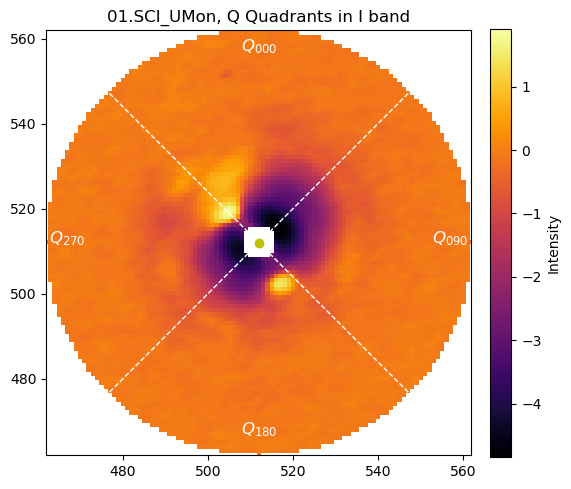

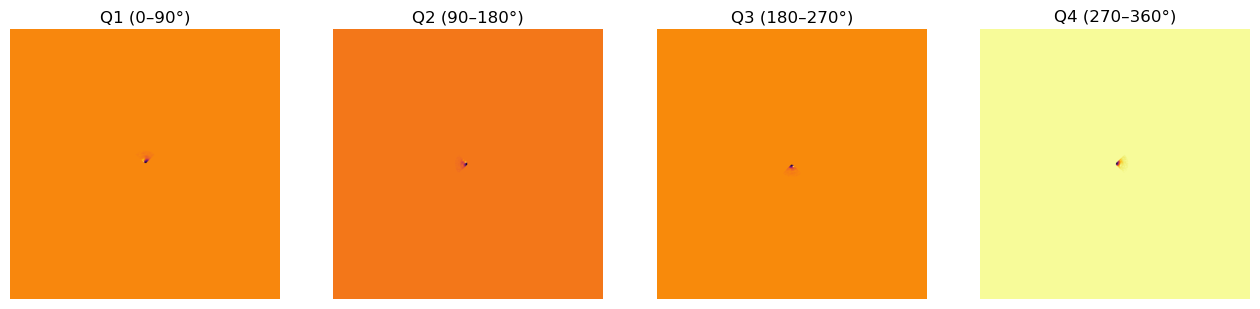

Q_disk in I
 
Quadrant sums: -734.9313330449885 -655.7072255847092 -657.8575196273431 -911.4740401125634
Left/right ratio: -0.10558694596980131
Back/front ratio: 1.2427845051470565
 


In [64]:
# Load + Quadrant Q_phi
q_i_results = QPHIquadrant_polarisation(q_i, center=(512,512),  r_in=4, r_out=50, stokes='Q')

q_i_dQ_NS  = q_i_results["Q000_norm"] / q_i_results["Q180_norm"]
q_i_dQ_EW  = q_i_results["Q090_norm"] / q_i_results["Q270_norm"]

print("Q_disk in I")
print(" ")
print("Quadrant sums:", q_i_results["Q000"], q_i_results["Q090"], q_i_results["Q180"], q_i_results["Q270"])
print("Left/right ratio:", q_i_results["ratios"]["090/270"])
print("Back/front ratio:", q_i_results["ratios"]["000/180"])
print(" ")
# print("Normalised quadrant sums:", q_i_results["Q000_norm"], q_i_results["Q090_norm"], q_i_results["Q180_norm"], q_i_results["Q270_norm"])
# print("Normalised North/South ratio:",q_i_dQ_NS)
# print("Normalised East/West ratio:",q_i_dQ_EW)

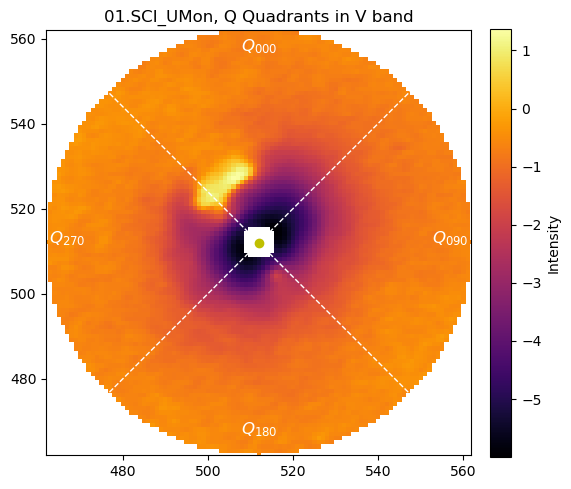

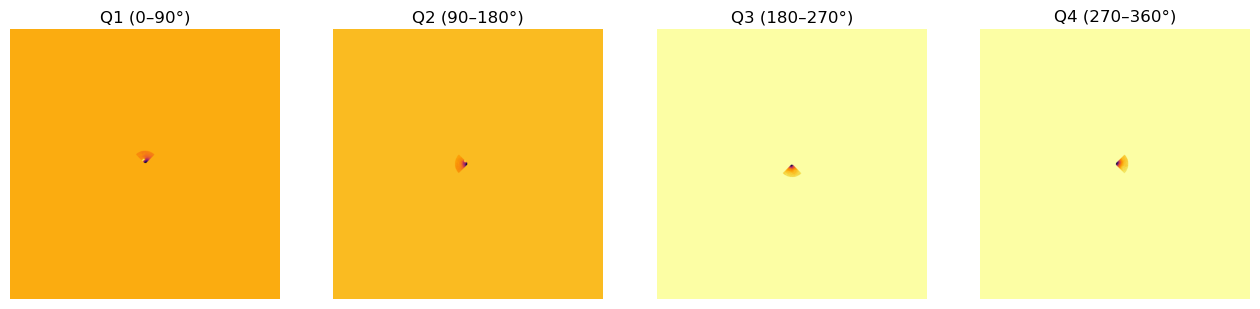

Q_disk in V
 
Quadrant sums: -2065.306995201654 -2039.2280115055069 -2195.3376114687326 -2400.06935704766
Left/right ratio: -0.07539890907453323
Back/front ratio: 0.9816328353222418
 


In [65]:
# Load + Quadrant Q_phi
q_v_results = QPHIquadrant_polarisation(q_v, center=(512,512),  r_in=4, r_out=50, stokes='Q',band='V')

q_v_dQ_NS  = q_v_results["Q000_norm"] + q_v_results["Q090_norm"] - q_v_results["Q180_norm"] - q_v_results["Q270_norm"]
q_v_dQ_EW  = q_v_results["Q090_norm"] + q_v_results["Q180_norm"] - q_v_results["Q000_norm"] - q_v_results["Q270_norm"]

print("Q_disk in V")
print(" ")
print("Quadrant sums:", q_v_results["Q000"], q_v_results["Q090"], q_v_results["Q180"], q_v_results["Q270"])
print("Left/right ratio:", q_v_results["ratios"]["090/270"])
print("Back/front ratio:", q_v_results["ratios"]["000/180"])
print(" ")
# print("Normalised quadrant sums:", q_v_results["Q000_norm"], q_v_results["Q090_norm"], q_v_results["Q180_norm"], q_v_results["Q270_norm"])
# print("Normalised North/South ratio:",q_v_dQ_NS)
# print("Normalised East/West ratio:",q_v_dQ_EW)

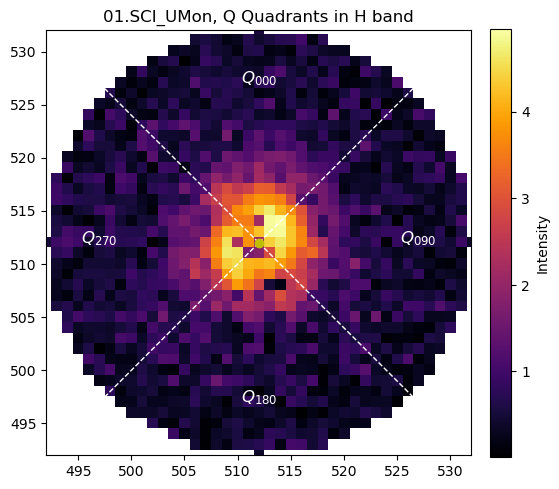

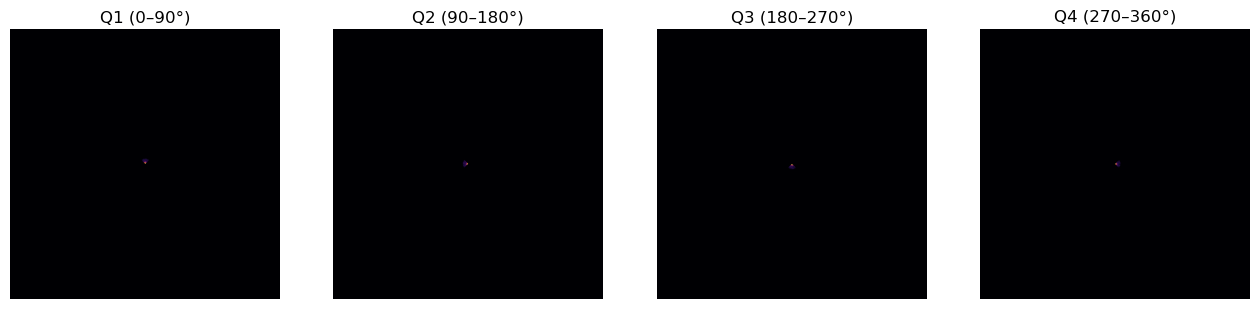

Q_disk in I
 
Quadrant sums: 289.0233369620459 279.65170320976955 249.373941940914 262.9638441335266
Left/right ratio: 0.030754480143351016
Back/front ratio: 1.1589957423479569
 


In [67]:
# Load + Quadrant Q_phi
if band[0] == 'H':
    q_h_results = QPHIquadrant_polarisation(q_h, center=(512,512),  r_in=0, r_out=20, stokes='Q',band='H')

    q_h_dQ_NS  = q_h_results["Q000_norm"] / q_h_results["Q180_norm"]
    q_h_dQ_EW  = q_h_results["Q090_norm"] / q_h_results["Q270_norm"]

    print("Q_disk in I")
    print(" ")
    print("Quadrant sums:", q_h_results["Q000"], q_h_results["Q090"], q_h_results["Q180"], q_h_results["Q270"])
    print("Left/right ratio:", q_h_results["ratios"]["090/270"])
    print("Back/front ratio:", q_h_results["ratios"]["000/180"])
    print(" ")
# print("Normalised quadrant sums:", q_i_results["Q000_norm"], q_i_results["Q090_norm"], q_i_results["Q180_norm"], q_i_results["Q270_norm"])
# print("Normalised North/South ratio:",q_i_dQ_NS)
# print("Normalised East/West ratio:",q_i_dQ_EW)

#### Q_phi

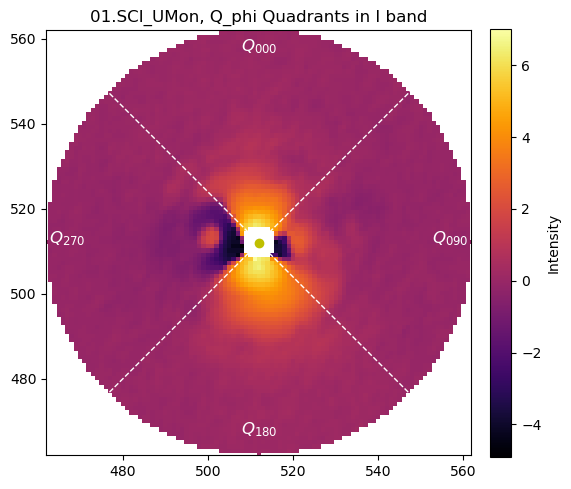

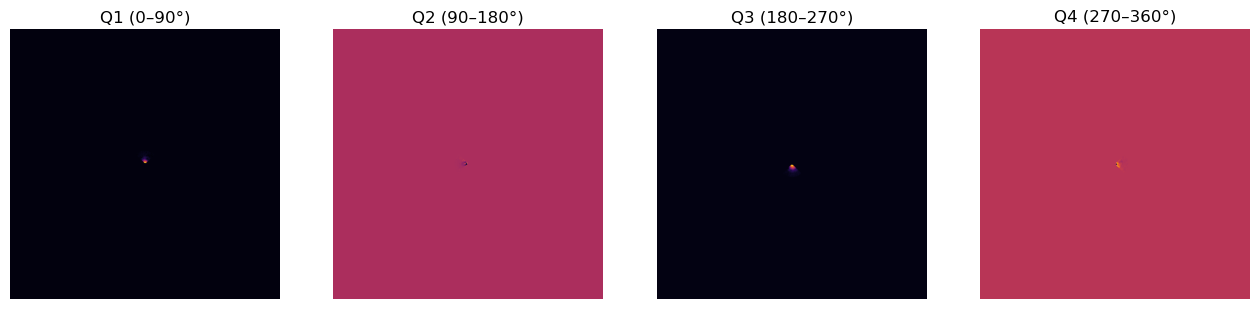

Q_disk in I
 
Quadrant sums: 876.2784258320298 -349.5689503719335 1553.9196579520355 274.39563997451216
Left/right ratio: -0.002870035427631261
Back/front ratio: 0.5712573453255959
 


In [68]:
q_phi_i_results = QPHIquadrant_polarisation(q_phi_i, center=(512,512),  r_in=4, r_out=50, stokes='Q_phi',band='I')

q_phi_i_dQ_NS  = q_phi_i_results["Q000_norm"] / q_phi_i_results["Q180_norm"]
q_phi_i_dQ_EW  = q_phi_i_results["Q090_norm"] / q_phi_i_results["Q270_norm"]

print("Q_disk in I")
print(" ")
print("Quadrant sums:", q_phi_i_results["Q000"], q_phi_i_results["Q090"], q_phi_i_results["Q180"], q_phi_i_results["Q270"])
print("Left/right ratio:", q_phi_i_results["ratios"]["090/270"])
print("Back/front ratio:", q_phi_i_results["ratios"]["000/180"])
print(" ")

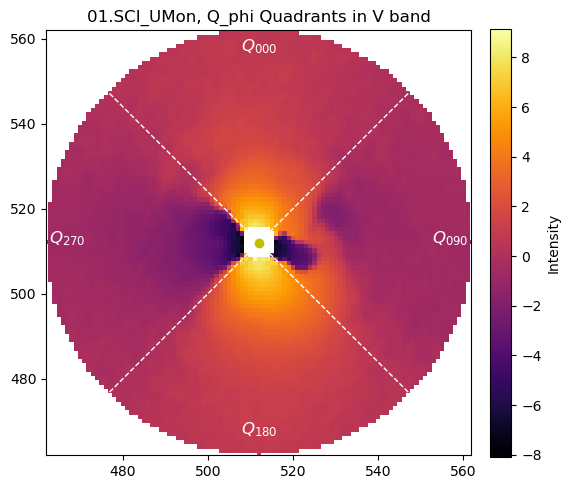

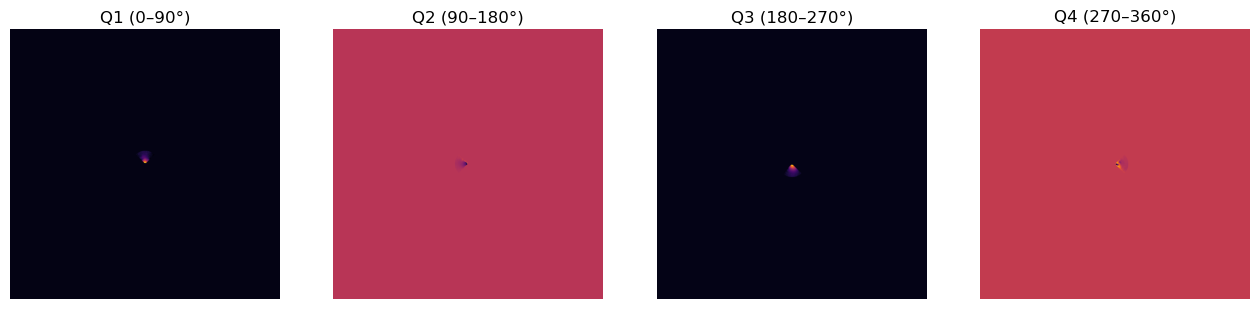

Q_disk in V
 
Quadrant sums: 2230.053410433948 -1698.2070901284205 3152.3944836425967 274.39563997451216
Left/right ratio: 0.054274993776800784
Back/front ratio: 0.7099457410576145
 


In [69]:
q_phi_v_results = QPHIquadrant_polarisation(q_phi_v, center=(512,512),  r_in=4, r_out=50, stokes='Q_phi',band='V')

q_phi_v_dQ_NS  = q_phi_v_results["Q000_norm"] / q_phi_v_results["Q180_norm"]
q_phi_v_dQ_EW  = q_phi_v_results["Q090_norm"] / q_phi_v_results["Q270_norm"]

print("Q_disk in V")
print(" ")
print("Quadrant sums:", q_phi_v_results["Q000"], q_phi_v_results["Q090"], q_phi_v_results["Q180"], q_phi_i_results["Q270"])
print("Left/right ratio:", q_phi_v_results["ratios"]["090/270"])
print("Back/front ratio:", q_phi_v_results["ratios"]["000/180"])
print(" ")

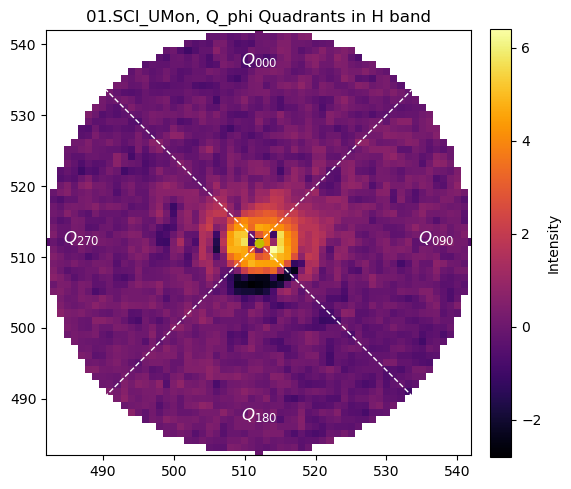

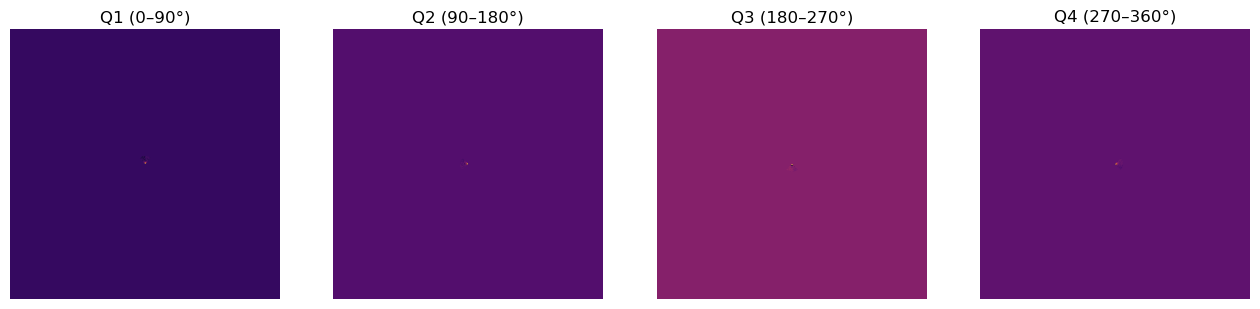

Q_disk in V
 
Quadrant sums: 99.05059136134521 135.50597328635902 16.39090051956383 274.39563997451216
Left/right ratio: -0.08206168727853273
Back/front ratio: 0.9716983361179278
 


In [72]:
if band[0] == 'H':
    q_phi_h_results = QPHIquadrant_polarisation(q_phi_h, center=(512,512),  r_in=0, r_out=30, stokes='Q_phi',band='H')

    q_phi_h_dQ_NS  = q_phi_h_results["Q000_norm"] / q_phi_h_results["Q180_norm"]
    q_phi_h_dQ_EW  = q_phi_h_results["Q090_norm"] / q_phi_h_results["Q270_norm"]

    print("Q_disk in V")
    print(" ")
    print("Quadrant sums:", q_phi_h_results["Q000"], q_phi_h_results["Q090"], q_phi_h_results["Q180"], q_phi_i_results["Q270"])
    print("Left/right ratio:", q_phi_h_results["ratios"]["090/270"])
    print("Back/front ratio:", q_phi_h_results["ratios"]["000/180"])
    print(" ")

#### U_disk

In [84]:
def UPHIquadrant_polarisation(Qphi, center=None, r_in=0, r_out=None, stokes = 'U', band='I'):
    """
    Compute quadrant-integrated Q_phi/U_phi values.

    North = up, South = down, East = left, West = right

    Q_phi:
      - 0° = North-West, 90° = North-East, 180° = South-East, 270° = South-West
    """

    ny, nx = Qphi.shape
    if center is None:
        cx, cy = (nx-1)/2, (ny-1)/2
    else:
        cx, cy = center

    # pixel grids
    y, x = np.indices(Qphi.shape)
    dx, dy = x - cx, y - cy
    r = np.sqrt(dx**2 + dy**2)
    pa = (np.degrees(np.arctan2(dy, dx)) + 360) % 360  # Position angle [0,360)
    # pa = (np.degrees(np.arctan2(dy, dx)) + 360) % 360

    # annulus mask
    if r_out is None:
        r_out = np.max(r)
    mask = (r >= r_in) & (r <= r_out)

    # quadrants
    q1 = mask & (pa >= 90)   & (pa < 180)   # N 45
    q2 = mask & (pa >= 180)  & (pa < 270)   # E 135
    q3 = mask & (pa >= 270) & (pa < 360)    # S 225
    q4 = mask & (pa >= 0) & (pa < 00)       # W 315
    # q1 = mask & (pa >= 45)   & (pa < 135)   #N
    # q2 = mask & (pa >= 135)  & (pa < 225)  #E
    # q3 = mask & (pa >= 225) & (pa < 315)  #S
    # q4 = mask & (pa >= 315) & (pa < 45)  #W

    # integrate
    Q1 = np.sum(Qphi[q1])
    Q2 = np.sum(Qphi[q2])
    Q3 = np.sum(Qphi[q3])
    Q4 = np.sum(Qphi[q4])

    Q1_abs = np.sum(np.abs(Qphi[q1]))
    Q2_abs = np.sum(np.abs(Qphi[q2]))
    Q3_abs = np.sum(np.abs(Qphi[q3]))
    Q4_abs = np.sum(np.abs(Qphi[q4]))

    # ratios
    ratios = {
        "045/135": Q1_abs/Q2_abs,  # Backside vs Front
        "315/225": Q4_abs/Q3_abs,  # East vs West
    }

        # --- Plot overlay ---

    image = Qphi.copy()
    plot_mask = mask.astype(float)
    plot_mask[plot_mask == 0] = np.nan   # hide everything outside r_in–r_out
    Qphi = image * plot_mask

    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(Qphi, origin="lower", cmap="hot")
    ax.set_title(f'{star}, U Quadrants in {band} band')
    ax.set_ylim(512-r_out,512+r_out)
    ax.set_xlim(512-r_out,512+r_out)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Intensity")

    # draw cross-lines for quadrants
    ax.plot([cx, cx], [0, ny], "w--", lw=1)
    ax.plot([0, nx], [cy, cy], "w--", lw=1)

    # mark center
    ax.plot(cx, cy, "yo", markersize=6)

    # quadrant labels
    ax.text(cx+r_out-10, cy+r_out-10, "$U_{270}$", color="white", fontsize=12, ha="left")   # top-right
    ax.text(cx-r_out/2, cy+r_out/2, "$U_{000}$", color="white", fontsize=12, ha="right")  # top-left
    ax.text(cx-r_out/2, cy-r_out/2, "$U_{090}$", color="white", fontsize=12, ha="right")  # bottom-left
    ax.text(cx+r_out/2, cy-r_out/2, "$U_{180}$", color="white", fontsize=12, ha="left")   # bottom-right

    plt.savefig(figfolder+f'/{star}_{stokes}_{band}_quadrants.png',dpi=300)

    plt.show()
    Q_sum = Q1 + Q2 + Q3 + Q4

    return {"Q000": Q1, "Q090": Q2, "Q180": Q3, "Q270": Q4, "ratios": ratios,
            "Q000_norm": Q1/Q_sum, "Q090_norm": Q2/Q_sum, "Q180_norm": Q3/Q_sum, "Q270_norm": Q4/Q_sum,
            "Q000_abs":Q1_abs, "Q090_abs": Q2_abs, "Q180_abs": Q3_abs, "Q270_abs": Q4_abs}

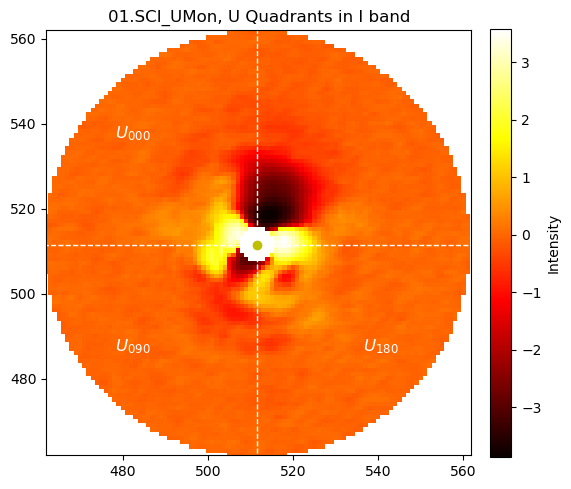

Q_PHI
 
Quadrant sums: -22.433923974729694 -97.33579036686696 155.1850402594174 0.0
Back/Front ratio: 1.4032803914721004
Back/Front ratio: 0.0
 


In [85]:
u_i_results = UPHIquadrant_polarisation(u_i, r_in=4, r_out=50, stokes = 'U', band='I')

u_i_dQ_NS  = u_i_results["Q000_norm"] + u_i_results["Q090_norm"] - u_i_results["Q180_norm"] - u_i_results["Q270_norm"]
u_i_dQ_EW  = u_i_results["Q090_norm"] + u_i_results["Q180_norm"] - u_i_results["Q000_norm"] - u_i_results["Q270_norm"]

print("Q_PHI")
print(" ")
print("Quadrant sums:", u_i_results["Q000"], u_i_results["Q090"], u_i_results["Q180"], u_i_results["Q270"])
print("Back/Front ratio:", u_i_results["ratios"]["045/135"])
print("Back/Front ratio:", u_i_results["ratios"]["315/225"])
print(" ")
# print("Normalised quadrant sums:", results["Q000_norm"], results["Q090_norm"], results["Q180_norm"], results["Q270_norm"])
# print("Normalised North/South ratio:",dQ_NS)
# print("Normalised East/West ratio:",dQ_EW)

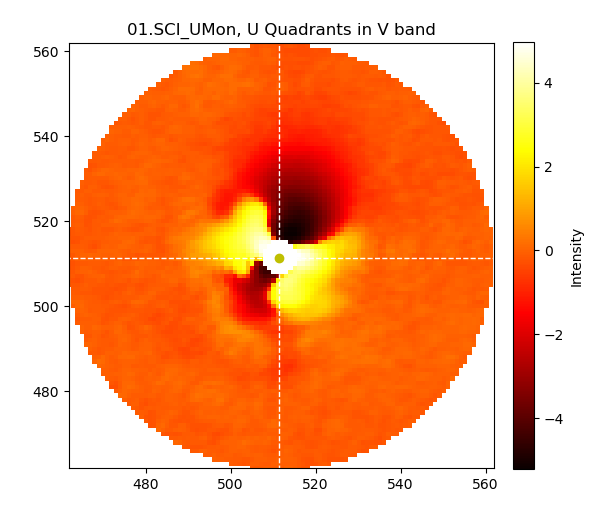

U
 
Quadrant sums: -44.04366694581282 -299.4042487135913 395.0754987077972 0.0
Back/Front ratio: 1.5878531668678526
Back/Front ratio: 0.0
 


In [75]:
u_v_results = UPHIquadrant_polarisation(u_v, r_in=4, r_out=50, stokes = 'U', band='V')

u_v_dQ_NS  = u_v_results["Q000_norm"] + u_v_results["Q090_norm"] - u_v_results["Q180_norm"] - u_v_results["Q270_norm"]
u_v_dQ_EW  = u_v_results["Q090_norm"] + u_v_results["Q180_norm"] - u_v_results["Q000_norm"] - u_v_results["Q270_norm"]

print("U")
print(" ")
print("Quadrant sums:", u_v_results["Q000"], u_v_results["Q090"], u_v_results["Q180"], u_v_results["Q270"])
print("Back/Front ratio:", u_v_results["ratios"]["045/135"])
print("Back/Front ratio:", u_v_results["ratios"]["315/225"])
print(" ")
# print("Normalised quadrant sums:", results["Q000_norm"], results["Q090_norm"], results["Q180_norm"], results["Q270_norm"])
# print("Normalised North/South ratio:",dQ_NS)
# print("Normalised East/West ratio:",dQ_EW)

### Calculating values

In [19]:
def QPHI_sum(Qphi, center=None, r_in=0, r_out=None):
    """
    Compute quadrant-integrated Q_phi/U_phi values.

    North = up, South = down, East = left, West = right

    Q_phi:
      - 0° = North-West, 90° = North-East, 180° = South-East, 270° = South-West
    """

    ny, nx = Qphi.shape
    if center is None:
        cx, cy = (nx-1)/2, (ny-1)/2
    else:
        cx, cy = center

    # pixel grids
    y, x = np.indices(Qphi.shape)
    dx, dy = x - cx,  y - cy
    r = np.sqrt(dx**2 + dy**2)
    pa = (np.degrees(np.arctan2(dy, dx)) + 360) % 360  # Position angle [0,360)

    # annulus mask
    if r_out is None:
        r_out = np.max(r)
    mask = (r >= r_in) & (r <= r_out)

    Qphi = Qphi[mask]
    Qphi_sum = np.nansum(Qphi)

    return Qphi_sum

In [20]:
Qphi_sumi = QPHI_sum(q_phi_i,r_in=4,r_out=50)
Qphi_sumv = QPHI_sum(q_phi_v,r_in=4,r_out=50)

In [21]:
# save to txt
with open(f"{figfolder}/quadrant_results_Iband.txt", "w") as f:
    f.write("############# I band ##################\n\n")

    f.write("Relative quadrant polarisation\n")
    f.write(f"Q000/Qφ: {q_i_results['Q000']/Qphi_sumi}\n")
    f.write(f"Q090/Qφ: {q_i_results['Q090']/Qphi_sumi}\n")
    f.write(f"Q180/Qφ: {q_i_results['Q180']/Qphi_sumi}\n")
    f.write(f"Q270/Qφ: {q_i_results['Q270']/Qphi_sumi}\n\n")

    f.write("Quadrant sums\n")
    f.write(f"ΣQxxx/Qφ: {(q_i_results['Q000']+q_i_results['Q090']+q_i_results['Q180']+q_i_results['Q270'])/Qphi_sumi}\n")
    f.write(f"Σ|Qxxx|/Qφ: {(q_i_results['Q000_abs']+q_i_results['Q090_abs']+q_i_results['Q180_abs']+q_i_results['Q270_abs'])/Qphi_sumi}\n\n")

    f.write("Relative quadrant polarisation\n")
    f.write(f"U045/Qφ: {u_i_results['Q000']/Qphi_sumi}\n")
    f.write(f"U135/Qφ: {u_i_results['Q090']/Qphi_sumi}\n")
    f.write(f"U225/Qφ: {u_i_results['Q180']/Qphi_sumi}\n")
    f.write(f"U315/Qφ: {u_i_results['Q270']/Qphi_sumi}\n\n")

    f.write("Quadrant sums\n")
    f.write(f"ΣUxxx/Qφ: {(u_i_results['Q000']+u_i_results['Q090']+u_i_results['Q180']+u_i_results['Q270'])/Qphi_sumi}\n")
    f.write(f"Σ|Uxxx|/Qφ: {(u_i_results['Q000_abs']+u_i_results['Q090_abs']+u_i_results['Q180_abs']+u_i_results['Q270_abs'])/Qphi_sumi}\n\n")

    f.write("Assymmetry parameters\n")
    f.write(f"Left/right ratio 090/270:  {q_i_results["ratios"]["090/270"]}\n")
    f.write(f"Back/front ratio 000/180:, {q_i_results["ratios"]["000/180"]}\n")
    f.write(f"Back/Front ratio 045/135:, {u_i_results["ratios"]["045/135"]}\n")
    f.write(f"Back/Front ratio 315/225:, {u_i_results["ratios"]["315/225"]}\n")


In [22]:
print("############# I band ##################")
print(" ")
print("Relative quadrant polarisation")
print("Q000/Qφ: ", q_i_results["Q000"]/Qphi_sumi)
print("Q090/Qφ: ", q_i_results["Q090"]/Qphi_sumi)
print("Q180/Qφ: ", q_i_results["Q180"]/Qphi_sumi)
print("Q270/Qφ: ", q_i_results["Q270"]/Qphi_sumi)
print(" ")
print("Quadrant sums")
print("ΣQxxx/Qφ: ",(q_i_results["Q000"]+q_i_results["Q090"]+q_i_results["Q180"]+q_i_results["Q270"])/Qphi_sumi)
print("Σ|Qxxx|/Qφ: ",(q_i_results["Q000_abs"]+q_i_results["Q090_abs"]+q_i_results["Q180_abs"]+q_i_results["Q270_abs"])/Qphi_sumi)
print(" ")
print("Relative quadrant polarisation")
print("U045/Qφ: ", u_i_results["Q000"]/Qphi_sumi)
print("U135/Qφ: ", u_i_results["Q090"]/Qphi_sumi)
print("U225/Qφ: ", u_i_results["Q180"]/Qphi_sumi)
print("U315/Qφ: ", u_i_results["Q270"]/Qphi_sumi)
print(" ")
print("Quadrant sums")
print("ΣUxxx/Qφ: ",(u_i_results["Q000"]+u_i_results["Q090"]+u_i_results["Q180"]+u_i_results["Q270"])/Qphi_sumi)
print("Σ|Uxxx|/Qφ: ",(u_i_results["Q000_abs"]+u_i_results["Q090_abs"]+u_i_results["Q180_abs"]+u_i_results["Q270_abs"])/Qphi_sumi)

############# I band ##################
 
Relative quadrant polarisation
Q000/Qφ:  -0.3131569988181913
Q090/Qφ:  -0.27939930934328605
Q180/Qφ:  -0.28031555770376604
Q270/Qφ:  -0.3883825087708832
 
Quadrant sums
ΣQxxx/Qφ:  -1.2612543746361267
Σ|Qxxx|/Qφ:  1.3700209038946056
 
Relative quadrant polarisation
U045/Qφ:  -0.009559179188257263
U135/Qφ:  -0.04147514552494767
U225/Qφ:  0.06612492798173362
U315/Qφ:  0.0
 
Quadrant sums
ΣUxxx/Qφ:  0.015090603268528695
Σ|Uxxx|/Qφ:  0.49130948411810776


In [23]:
# save to txt
with open(f"{figfolder}/quadrant_results_Vband.txt", "w") as f:
    f.write("############# V band ##################\n\n")

    f.write("Relative quadrant polarisation\n")
    f.write(f"Q000/Qφ: {q_v_results['Q000']/Qphi_sumv}\n")
    f.write(f"Q090/Qφ: {q_v_results['Q090']/Qphi_sumv}\n")
    f.write(f"Q180/Qφ: {q_v_results['Q180']/Qphi_sumv}\n")
    f.write(f"Q270/Qφ: {q_v_results['Q270']/Qphi_sumv}\n\n")

    f.write("Quadrant sums\n")
    f.write(f"ΣQxxx/Qφ: {(q_v_results['Q000']+q_v_results['Q090']+q_v_results['Q180']+q_v_results['Q270'])/Qphi_sumv}\n")
    f.write(f"Σ|Qxxx|/Qφ: {(q_v_results['Q000_abs']+q_v_results['Q090_abs']+q_v_results['Q180_abs']+q_v_results['Q270_abs'])/Qphi_sumv}\n\n")

    f.write("Relative quadrant polarisation\n")
    f.write(f"U045/Qφ: {u_v_results['Q000']/Qphi_sumv}\n")
    f.write(f"U135/Qφ: {u_v_results['Q090']/Qphi_sumv}\n")
    f.write(f"U225/Qφ: {u_v_results['Q180']/Qphi_sumv}\n")
    f.write(f"U315/Qφ: {u_v_results['Q270']/Qphi_sumv}\n\n")

    f.write("Quadrant sums\n")
    f.write(f"ΣUxxx/Qφ: {(u_v_results['Q000']+u_v_results['Q090']+u_v_results['Q180']+u_v_results['Q270'])/Qphi_sumi}\n")
    f.write(f"Σ|Uxxx|/Qφ: {(u_v_results['Q000_abs']+u_v_results['Q090_abs']+u_v_results['Q180_abs']+u_v_results['Q270_abs'])/Qphi_sumv}\n")

    f.write("Assymmetry parameters\n")
    f.write(f"Left/right ratio 090/270:  {q_v_results["ratios"]["090/270"]}\n")
    f.write(f"Back/front ratio 000/180:, {q_v_results["ratios"]["000/180"]}\n")
    f.write(f"Back/Front ratio 045/135:, {u_v_results["ratios"]["045/135"]}\n")
    f.write(f"Back/Front ratio 315/225:, {u_v_results["ratios"]["315/225"]}\n")

In [24]:
print("############# V band ##################")
print(" ")
print("Relative quadrant polarisation")
print("Q000/Qφ: ", q_v_results["Q000"]/Qphi_sumv)
print("Q090/Qφ: ", q_v_results["Q090"]/Qphi_sumv)
print("Q180/Qφ: ", q_v_results["Q180"]/Qphi_sumv)
print("Q270/Qφ: ", q_v_results["Q270"]/Qphi_sumv)
print(" ")
print("Quadrant sums")
print("ΣQxxx/Qφ: ",(q_v_results["Q000"]+q_v_results["Q090"]+q_v_results["Q180"]+q_v_results["Q270"])/Qphi_sumv)
print("Σ|Qxxx|/Qφ: ",(q_v_results["Q000_abs"]+q_v_results["Q090_abs"]+q_v_results["Q180_abs"]+q_v_results["Q270_abs"])/Qphi_sumv)
print(" ")
print("Relative quadrant polarisation")
print("U045/Qφ: ", u_v_results["Q000"]/Qphi_sumv)
print("U135/Qφ: ", u_v_results["Q090"]/Qphi_sumv)
print("U225/Qφ: ", u_v_results["Q180"]/Qphi_sumv)
print("U315/Qφ: ", u_v_results["Q270"]/Qphi_sumv)
print(" ")
print("Quadrant sums")
print("ΣUxxx/Qφ: ",(u_v_results["Q000"]+u_v_results["Q090"]+u_v_results["Q180"]+u_v_results["Q270"])/Qphi_sumv)
print("Σ|Uxxx|/Qφ: ",(u_v_results["Q000_abs"]+u_v_results["Q090_abs"]+u_v_results["Q180_abs"]+u_v_results["Q270_abs"])/Qphi_sumv)

############# V band ##################
 
Relative quadrant polarisation
Q000/Qφ:  -0.6221772516932851
Q090/Qφ:  -0.6143209134148983
Q180/Qφ:  -0.6613491964225654
Q270/Qφ:  -0.7230249836515864
 
Quadrant sums
ΣQxxx/Qφ:  -2.620872345182335
Σ|Qxxx|/Qφ:  2.655215068098143
 
Relative quadrant polarisation
U045/Qφ:  -0.013268229720087987
U135/Qφ:  -0.09019604012512757
U225/Qφ:  0.1190171672145869
U315/Qφ:  0.0
 
Quadrant sums
ΣUxxx/Qφ:  0.015552897369371349
Σ|Uxxx|/Qφ:  0.6870757991959149


### Inner rim Qphi profile

In [25]:
from photutils.aperture import CircularAnnulus
from scipy.ndimage import gaussian_filter

def radial_profile(image, center, radii, dr=1):
    """
    Compute azimuthally averaged radial profile.

    image : 2D array (Qphi map)
    center : (x0, y0)
    radii : array of radii to sample (pixels)
    dr : annulus thickness (pixels)
    """
    profile = []
    for r in radii:
        annulus = CircularAnnulus(center, r_in=r, r_out=r+dr)
        mask = annulus.to_mask(method="center")
        annulus_data = mask.multiply(image)
        # valid pixels only
        values = annulus_data[mask.data > 0]
        if len(values) > 0:
            profile.append(np.mean(values))
        else:
            profile.append(np.nan)
    return np.array(profile)

def gaus(x,a,x0,sigma):
            return a*np.exp(-(x-x0)**2/(2*sigma**2))

def find_FWHM (PSF,n):             #resolution
    middle=int(n/2)

    y1=PSF[middle,middle-60:middle+60]
    y2=PSF[middle-60:middle+60,middle]

    xdata = np.linspace(middle-60,middle+60, num=len(y1))


    n_gauss = len(xdata) #the number of data
    amp=np.max(y1)
    mean = np.sum(xdata * y1) / sum(y1)
    sigma = np.sqrt(sum(y1 * (xdata - mean)**2) / sum(y1))

    popt1,pcov1 = curve_fit(gaus,xdata,y1,p0=[amp,mean,sigma])
    popt2,pcov2 = curve_fit(gaus,xdata,y2,p0=[amp,mean,sigma])

    fwhm1=2*np.sqrt(2*math.log(2))*popt1[2]
    fwhm2=2.355*popt2[2]


    fwhm=(abs(fwhm1)+abs(fwhm2))/2

    return fwhm


In [26]:
# psf_i = fits.open('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/REF_HD75885/PSF_models/Iband_qphi_circular_f_psf_50.fits')[0].data
psf_i= fits.open('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/REF_HD71253/PSF_models/REF_HD71253Vband_qphi_ellipse_pa144_i25_f_psf_50.fits')[0].data

psf_i= fits.open('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/REF_HD71253/PSF_models/Iband_pi_circular_f_psf_50.fits')[0].data

In [27]:
ps = 3.6
# Qphi = q_phi_i
n = psf_i.shape[0]
psf_i_fwhm_pix = find_FWHM(psf_i,n)
print(psf_i_fwhm_pix)

9.449889295779482


In [28]:
center = (q_phi_i.shape[1]//2, q_phi_i.shape[0]//2)
radii = np.arange(1, q_phi_i.shape[0]//2, 1)

# intrinsic profile
Qphi_i_prof = radial_profile(q_phi_i, center, radii, dr=1)
Qphi_v_prof = radial_profile(q_phi_v, center, radii, dr=1)

# # convolved (with PSF)
# sigma_pix = psf_fwhm_pix / 2.355   # Gaussian sigma from FWHM
# Qphi_conv = gaussian_filter(Qphi, sigma=sigma_pix)
# Qphi_prof_conv = radial_profile(Qphi_conv, center, radii, dr=1)

<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_87729/1323371450.py:3: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(radii*ps, Qphi_i_prof, label="Convolved Q$_\phi$(r) I-band", lw=2)
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_87729/1323371450.py:4: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(radii*ps, Qphi_v_prof, label="Convolved Q$_\phi$(r) V-band", lw=2)


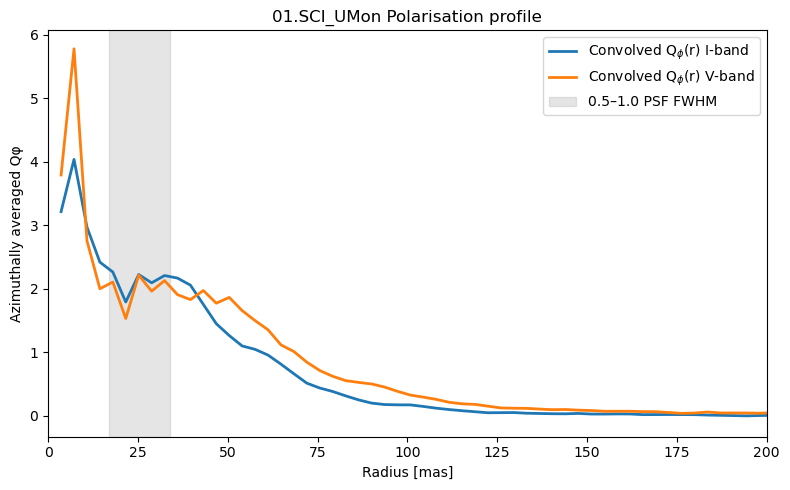

<Figure size 800x500 with 0 Axes>

In [29]:
# --- Plot ---
plt.figure(figsize=(8,5))
plt.plot(radii*ps, Qphi_i_prof, label="Convolved Q$_\phi$(r) I-band", lw=2)
plt.plot(radii*ps, Qphi_v_prof, label="Convolved Q$_\phi$(r) V-band", lw=2)
# plt.plot(radii*ps, Qphi_prof_conv, label="PSF-convolved Qφ(r)", lw=2, ls="--")
plt.xlim(0,200)
plt.axvspan(0.5*psf_i_fwhm_pix*ps, 1.0*psf_i_fwhm_pix*ps, color="grey", alpha=0.2,
            label="0.5–1.0 PSF FWHM")
plt.xlabel("Radius [mas]")
plt.ylabel("Azimuthally averaged Qφ")
plt.title(f"{star} Polarisation profile")
plt.legend()
plt.tight_layout()

plt.savefig(f"{figfolder}/{star}_innerrim_profile.png",dpi=300)
plt.figure(figsize=(8,5))

plt.show()

### Ratio between integrated polarisation parameters

In [30]:
stokesq_i = LoadImage(dirdat,f'{star}_I_Q_corr_tel+unres.fits')
stokesq_v = LoadImage(dirdat,f'{star}_V_Q_corr_tel+unres.fits')

stokesqphi_i = LoadImage(dirdat,f'{star}_I_Q_phi_corr_tel+unres.fits')
stokesqphi_v = LoadImage(dirdat,f'{star}_V_Q_phi_corr_tel+unres.fits')

In [31]:
rad_in = 0
rad_out = 0.5*psf_i_fwhm_pix

# Q_phi
Qphi_sum_i = QPHI_sum(stokesqphi_i,r_in=rad_in,r_out=rad_out)
Qphi_sum_v = QPHI_sum(stokesqphi_v,r_in=rad_in,r_out=rad_out)

# Stokes Q
Q_sum_i = QPHI_sum(stokesq_i,r_in=rad_in,r_out=rad_out)
Q_sum_v = QPHI_sum(stokesq_v,r_in=rad_in,r_out=rad_out)

In [32]:
rad_out = np.arange(1, 2*rad_out, 1)

q_phi_i_ratio_prof = radial_profile(stokesqphi_i, center, rad_out, dr=1)
q_phi_v_ratio_prof = radial_profile(stokesqphi_v, center, rad_out, dr=1)

q_i_ratio_prof = radial_profile(stokesq_i, center, rad_out, dr=1)
q_v_ratio_prof = radial_profile(stokesq_v, center, rad_out, dr=1)

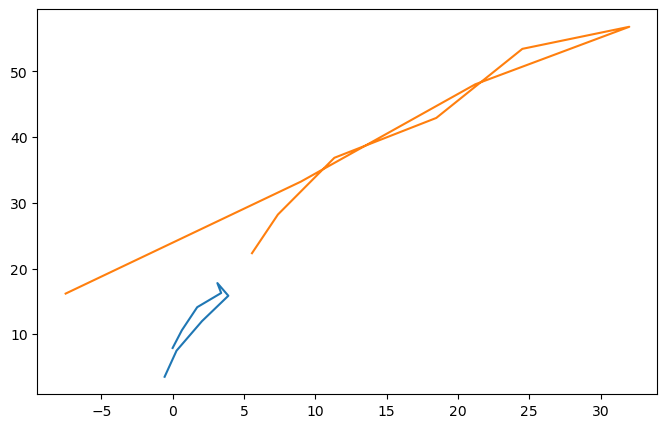

The sum of Q_phi in I band is:  689.1046335613025
The sum of Q_phi in V band is:  2654.0088422986573
The sum of Q in I band is:  111.09184
The sum of Q in V band is:  1224.6125
 
Ratio for D$_{PSF}$ < 0.5 in I-band is:  0.16121186426688638
Ratio for D$_{PSF}$ < 0.5 in V-band is:  0.46141992042780033


In [33]:
plt.figure(figsize=(8,5))
plt.plot(q_i_ratio_prof, q_phi_i_ratio_prof)
plt.plot(q_v_ratio_prof, q_phi_v_ratio_prof)
plt.show()

print("The sum of Q_phi in I band is: ", Qphi_sum_i)
print("The sum of Q_phi in V band is: ", Qphi_sum_v)
print("The sum of Q in I band is: ", Q_sum_i)
print("The sum of Q in V band is: ", Q_sum_v)
print(" ")
print("Ratio for D$_{PSF}$ < 0.5 in I-band is: ", Q_sum_i/Qphi_sum_i)
print("Ratio for D$_{PSF}$ < 0.5 in V-band is: ", Q_sum_v/Qphi_sum_v)

In [34]:
# save to txt
with open(f"{figfolder}/integrated_ratio.txt", "w") as f:
    f.write(f"############# {star} ##################\n\n")


    f.write(f"The sum of Q_phi in I band is: {Qphi_sum_i}\n")
    f.write(f"The sum of Q_phi in V band is: {Qphi_sum_v}\n")
    f.write(f"The sum of Q in I band is: {Q_sum_i}\n")
    f.write(f"The sum of Q in V band is: {Q_sum_v}\n\n")
    f.write(f"Ratio for D$_PSF$ < 0.5 in I-band is: {Q_sum_i / Qphi_sum_i}\n")
    f.write(f"Ratio for D$_PSF$ < 0.5 in V-band is: {Q_sum_v / Qphi_sum_v}\n")